In [74]:
import polars as pl
import json
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

plt.rcParams["font.family"] = "Hiragino Sans"


# JSONファイルの読み込み
files = glob.glob("jsons/*.json")
data_list = []

for file in files:
    with open(file, "r", encoding="utf-8") as f:
        json_data = json.load(f)
        market_date = json_data["market_condition"]["date"]
        shipped_volume = json_data["market_condition"]["shipped_volume"]

        for price_entry in json_data["prices"]:
            price_entry["date"] = market_date
            price_entry["shipped_volume"] = shipped_volume
            if price_entry["price_high"] == 0.0:
                price_entry["price_high"] = price_entry["price_low"]
            data_list.append(price_entry)

# PolarsのDataFrameに変換
df_polar = pl.DataFrame(data_list, infer_schema_length=1000)

In [75]:
# 統計情報の表示
df_polar.describe()

statistic,tree_species,diameter_class,length,top_diameter_min,top_diameter_max,price_low,price_middle,price_high,tone,summary,date,shipped_volume
str,str,str,f64,f64,f64,f64,f64,f64,str,str,str,f64
"""count""","""8348""","""8348""",8348.0,8348.0,8348.0,8348.0,253.0,8348.0,"""120""","""267""","""8348""",8348.0
"""null_count""","""0""","""0""",0.0,0.0,0.0,0.0,8095.0,0.0,"""8228""","""8081""","""0""",0.0
"""mean""",null,null,4.252911,18.272305,162.295352,17073.991375,17555.335968,21875.578462,null,null,null,1324.535577
"""std""",null,null,1.514895,22.113171,10950.152881,14179.320147,9533.717378,19001.538284,null,null,null,685.527737
"""min""","""その他""","""その他""",-1.0,-1.0,-1.0,0.0,0.0,-1.0,"""light""","""3m×16~18~20㎝は高値。""","""1993-07-06""",0.0
"""25%""",null,null,4.0,16.0,20.0,11000.0,11500.0,14000.0,null,null,null,850.0
"""50%""",null,null,4.0,16.0,20.0,13000.0,15000.0,18000.0,null,null,null,1200.0
"""75%""",null,null,4.3,24.0,26.0,20000.0,20500.0,25000.0,null,null,null,1670.0
"""max""","""元木良材""","""長木""",100.0,1000.0,1e6,400000.0,90000.0,500000.0,"""高値""","""４ｍ、６ｍ共""","""2025-02-06""",12000.0


In [76]:
df = df_polar.to_pandas()

In [100]:
# スギとヒノキのみを抽出
df = df[df['tree_species'].isin(['スギ', 'ヒノキ'])]

In [101]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ===========================================
# 1) データの読み込み
# ===========================================
# df = pd.read_csv('your_data.csv') などで読み込む想定
# 以下はサンプルとして df が既にある体で進めます

# 例: カラムが下記のようにあると想定
# 'tree_species', 'diameter_class', 'length', 'top_diameter_min', 'top_diameter_max',
# 'price_low', 'price_high', 'date', 'shipped_volume', など

# ===========================================
# 2) 前処理・欠損処理
# ===========================================
# (A) price_low, price_high が欠損の行を除外
df = df.dropna(subset=['price_low', 'price_high'])

# (B) 日付を datetime 型に変換して年・月を作成 (季節性の特徴量)
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# 必要に応じて日付が NaT になった行を除外
df = df.dropna(subset=['year', 'month'])

# ===========================================
# 3) 特徴量と目的変数の定義
# ===========================================
# 今回は例として以下を入力特徴量にします
#   - 数値列: ['length', 'top_diameter_min', 'top_diameter_max',
#              'shipped_volume', 'year', 'month']
#   - カテゴリ列: ['tree_species', 'diameter_class']
# テキスト列(tone, summary)などは今回は使用せず

num_cols = ['length', 'top_diameter_min', 'top_diameter_max',
            'shipped_volume', 'year', 'month']
cat_cols = ['tree_species', 'diameter_class']

# 説明変数 (X) と目的変数 (y)
X = df[num_cols + cat_cols].copy()
y = df[['price_low', 'price_high']].copy()

# ===========================================
# 4) パイプライン作成 (前処理 -> モデル)
# ===========================================
# (A) 数値列のパイプライン
# - 欠損値を中央値で補完
# - 必要なら対数変換や標準化を入れる
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())    # 必要であれば標準化
])

# (B) カテゴリ列のパイプライン
# - 欠損値を最頻値で補完
# - One-Hot エンコーディング
cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# (C) 列ごとの処理をまとめる
preprocessor = ColumnTransformer([
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
], remainder='drop')

# (D) 回帰モデル (ランダムフォレスト) を MultiOutputRegressor で包む
#     → price_low, price_high を同時に予測
model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))

# (E) 全体のパイプライン
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', model)
])

# ===========================================
# 5) 学習データとテストデータに分割
# ===========================================
# 時系列を意識するなら shuffle=False にして過去→未来の分割にするなど調整してください
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# ===========================================
# 6) モデル学習
# ===========================================
pipeline.fit(X_train, y_train)

# ===========================================
# 7) 予測 & 評価
# ===========================================
y_pred = pipeline.predict(X_test)

# y_pred は (N行, 2列) の numpy 配列 (price_low予測値, price_high予測値)
pred_low = y_pred[:, 0]
pred_high = y_pred[:, 1]

true_low = y_test['price_low'].values
true_high = y_test['price_high'].values

# MAE
mae_low = mean_absolute_error(true_low, pred_low)
mae_high = mean_absolute_error(true_high, pred_high)

print("MAE (low) :", mae_low)
print("MAE (high):", mae_high)

# RMSE
rmse_low = mean_squared_error(true_low, pred_low)
rmse_high = mean_squared_error(true_high, pred_high)

print("RMSE (low) :", rmse_low)
print("RMSE (high):", rmse_high)

MAE (low) : 2023.241339071102
MAE (high): 2877.9365910123065
RMSE (low) : 136756047.60819945
RMSE (high): 180395787.88282898


In [104]:
X_test

,length,top_diameter_min,top_diameter_max,shipped_volume,year,month,tree_species,diameter_class
6688,6.0,16.0,20.0,2600.0,2020,10,スギ,柱
6689,3.0,16.0,20.0,2600.0,2020,10,ヒノキ,柱
6690,6.0,16.0,20.0,2600.0,2020,10,ヒノキ,柱
6691,4.0,18.0,24.0,2600.0,2020,10,ヒノキ,中目
6692,4.0,24.0,30.0,2600.0,2020,10,ヒノキ,中目
...,...,...,...,...,...,...,...,...
8340,6.0,16.0,20.0,1300.0,2007,5,スギ,柱
8341,3.0,16.0,20.0,1300.0,2007,5,ヒノキ,柱
8342,6.0,16.0,20.0,1300.0,2007,5,ヒノキ,柱
8343,4.0,18.0,24.0,1300.0,2007,5,ヒノキ,中目


In [105]:
y_test

,price_low,price_high
6688,13000.0,15000.0
6689,10000.0,12000.0
6690,18000.0,20000.0
6691,12000.0,14000.0
6692,15000.0,18000.0
...,...,...
8340,11000.0,13000.0
8341,18000.0,23000.0
8342,23000.0,28000.0
8343,17000.0,23000.0


In [107]:
y_pred

array([[13020., 15010.],
       [11200., 13500.],
       [18110., 20320.],
       ...,
       [25180., 32450.],
       [17770., 23350.],
       [18500., 22220.]], shape=(1433, 2))

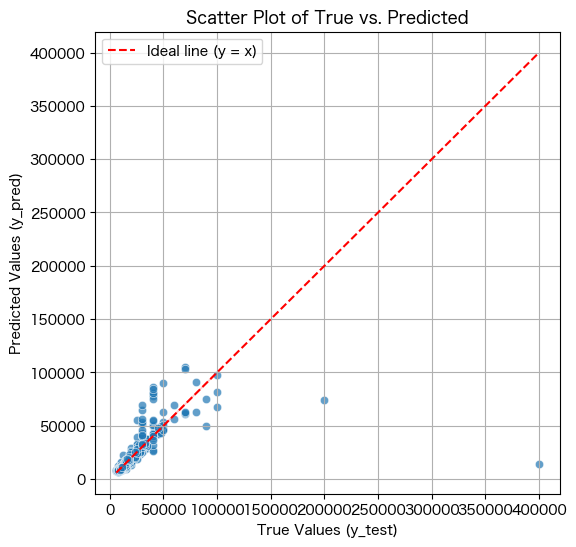

In [110]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test['price_low'].values, y=y_pred[:, 0], alpha=0.7)
sns.lineplot(x=y_test['price_low'].values, y=y_test['price_low'].values, color="red", linestyle="--", label="Ideal line (y = x)")
plt.xlabel("True Values (y_test)")
plt.ylabel("Predicted Values (y_pred)")
plt.title("Scatter Plot of True vs. Predicted")
plt.legend()
plt.grid()
plt.show()


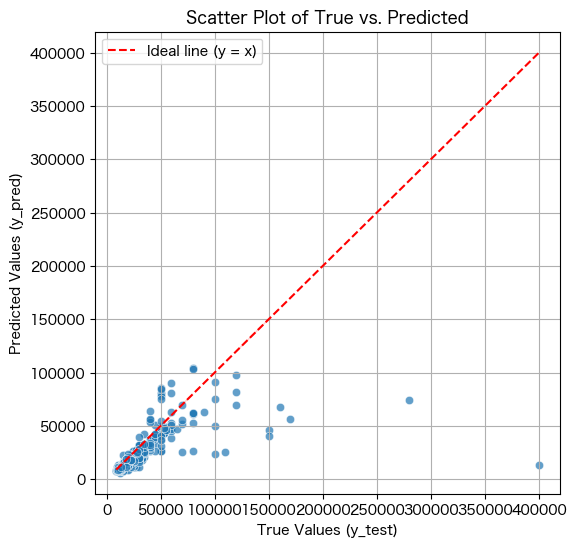

In [111]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test['price_high'].values, y=y_pred[:, 0], alpha=0.7)
sns.lineplot(x=y_test['price_high'].values, y=y_test['price_high'].values, color="red", linestyle="--", label="Ideal line (y = x)")
plt.xlabel("True Values (y_test)")
plt.ylabel("Predicted Values (y_pred)")
plt.title("Scatter Plot of True vs. Predicted")
plt.legend()
plt.grid()
plt.show()

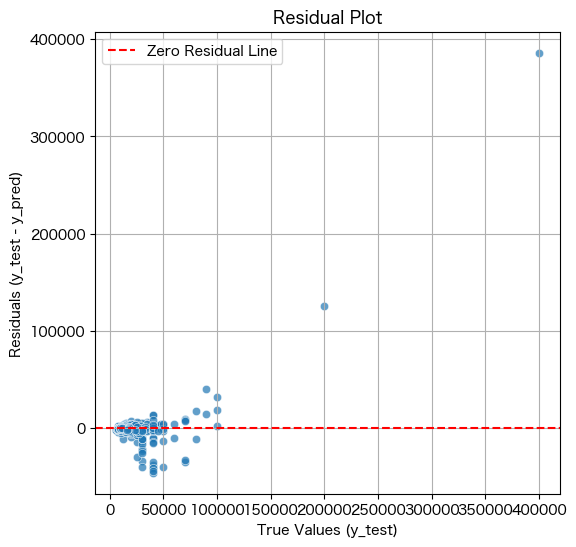

In [118]:
residuals = y_test - y_pred

plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test['price_low'].values, y=residuals.values[:,0], alpha=0.7)
plt.axhline(0, color="red", linestyle="--", label="Zero Residual Line")
plt.xlabel("True Values (y_test)")
plt.ylabel("Residuals (y_test - y_pred)")
plt.title("Residual Plot")
plt.legend()
plt.grid()
plt.show()

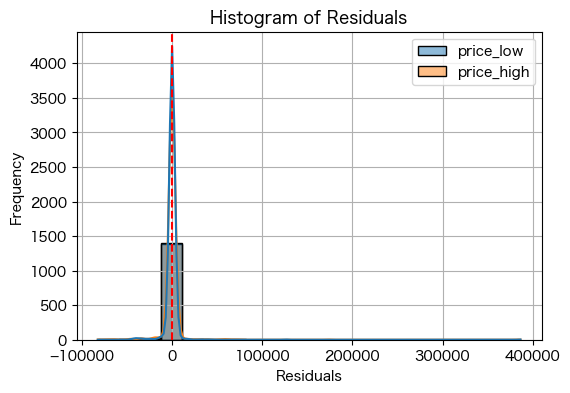

In [121]:
plt.figure(figsize=(6, 4))
sns.histplot(residuals, bins=20, kde=True, edgecolor="black")
plt.axvline(0, color="red", linestyle="--")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.grid()
plt.show()